# Generating Digits using GAN
In this project, I want to implement the most basic version of a GAN to generate MNIST-like images.

-- Gholamreza Dar, Nov 2024


loosely based on https://www.coursera.org/learn/build-basic-generative-adversarial-networks-gans

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

SEED = 69
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device: {device}")
print(f"torch version: {torch.__version__}")

device: cuda
torch version: 2.4.1+cu121


## Model

### get_noise function

In [2]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn((n_samples, z_dim), device=device)

In [3]:
get_noise(2, 3, device=device)

tensor([[-1.6594,  1.9279,  0.8757],
        [ 0.3105,  1.1376, -0.7348]], device='cuda:0')

### Generator


In [4]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

In [5]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim), # 128
            get_generator_block(hidden_dim, hidden_dim*2), # 256
            get_generator_block(hidden_dim*2, hidden_dim*4), # 512
            get_generator_block(hidden_dim*4, hidden_dim*8), # 1024
            nn.Linear(hidden_dim*8, im_dim), # 784
            nn.Sigmoid(), # output between 0 and 1
        )

    def forward(self, noise):
        return self.gen(noise)

In [6]:
def generator_loss(gen, disc, criterion, num_images, z_dim, device):
    noise = get_noise(num_images, z_dim, device=device)
    fake_images = gen(noise)
    y_pred = disc(fake_images)
    y_gt = torch.ones_like(y_pred)
    return criterion(y_pred, y_gt)

In [7]:
from torchsummary import summary
generator = Generator(z_dim=10, im_dim=784, hidden_dim=128).to(device)
summary(generator, (10,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,408
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 256]          33,024
       BatchNorm1d-5                  [-1, 256]             512
              ReLU-6                  [-1, 256]               0
            Linear-7                  [-1, 512]         131,584
       BatchNorm1d-8                  [-1, 512]           1,024
              ReLU-9                  [-1, 512]               0
           Linear-10                 [-1, 1024]         525,312
      BatchNorm1d-11                 [-1, 1024]           2,048
             ReLU-12                 [-1, 1024]               0
           Linear-13                  [-1, 784]         803,600
          Sigmoid-14                  [

## Discriminator


In [8]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [9]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim*4), # 512
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2), # 256
            get_discriminator_block(hidden_dim * 2, hidden_dim), # 128
            nn.Linear(hidden_dim, 1),
            # nn.Sigmoid(),
            # using a sigmoid followed by BCE is less numerically stable than BCEWithLogitsLoss alone
            # https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss:~:text=This%20loss%20combines%20a%20Sigmoid%20layer%20and%20the%20BCELoss%20in%20one%20single%20class.%20This%20version%20is%20more%20numerically%20stable%20than%20using%20a%20plain%20Sigmoid%20followed%20by%20a%20BCELoss%20as%2C%20by%20combining%20the%20operations%20into%20one%20layer%2C%20we%20take%20advantage%20of%20the%20log%2Dsum%2Dexp%20trick%20for%20numerical%20stability.
        )

    def forward(self, image_batch):
        '''image_batch -> (batch_size, 784)'''
        return self.disc(image_batch)

In [10]:
def discriminator_loss(gen, disc, criterion, real, num_images, z_dim, device, alpha=0.5):
    ''' alpha is the weight of the discriminator loss '''
    noise = get_noise(num_images, z_dim, device=device)
    fake_images = gen(noise)
    y_pred_real = disc(real)
    y_pred_fake = disc(fake_images)
    y_gt_real = torch.ones_like(y_pred_real)
    y_gt_fake = torch.zeros_like(y_pred_fake)

    average_loss = alpha * criterion(y_pred_real, y_gt_real) + (1 - alpha) * criterion(y_pred_fake, y_gt_fake)

    return average_loss

In [29]:
discriminator = Discriminator(im_dim=784, hidden_dim=128).to(device)
summary(discriminator, (784,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
         LeakyReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
         LeakyReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
         LeakyReLU-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
Total params: 566,273
Trainable params: 566,273
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.16
Estimated Total Size (MB): 2.18
----------------------------------------------------------------


## Data


In [12]:
from torchvision.datasets import MNIST
from torchvision import transforms

BATCH_SIZE = 64

dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE,
    shuffle=True
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:02<00:00, 4624021.62it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 136800.44it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1271696.30it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 3370581.88it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [13]:
batch = next(iter(dataloader))
images, labels = batch
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [33]:
def display_image_grid(images, num_rows=5, title=""):
    if(images.shape[-1]!=28):
        images = images.view(-1, 1, 28, 28)
    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.title(title)
    grid = make_grid(images.detach().cpu()[:25], nrow=num_rows).permute(1, 2, 0).numpy()
    # print(grid.shape)
    plt.imshow(grid)
    plt.show()

In [15]:
images.shape

torch.Size([64, 1, 28, 28])

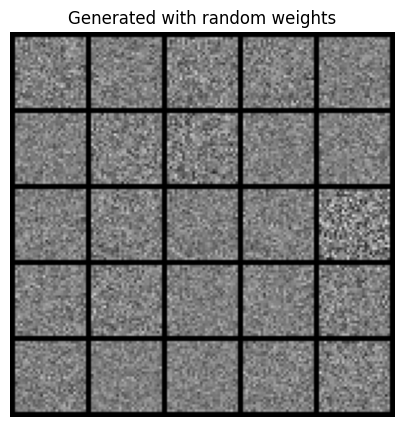

In [34]:
display_image_grid(generator(get_noise(25, 10, device=device)), title="Generated with random weights")

## Training

In [23]:
len(dataloader)

938

In [24]:
938*BATCH_SIZE

60032

In [25]:
def train_step(gen, disc, criterion, real, num_images, z_dim, device, alpha=0.5):
    pass

In [35]:
gen_losses = []
disc_losses = []
generator = Generator(z_dim=10, im_dim=784, hidden_dim=128).to(device)
discriminator = Discriminator(im_dim=784, hidden_dim=128).to(device)

def train(gen, disc, criterion, real, num_images, z_dim, device, alpha=0.5):
    EPOCHS = 100
    iter_count = 0

    opt_gen = torch.optim.Adam(gen.parameters(), lr=0.0001)
    opt_disc = torch.optim.Adam(disc.parameters(), lr=0.0001)

    gen.train()
    disc.train()

    for epoch in range(EPOCHS):
        for real, _ in dataloader:
            real = real.view(-1, 784).to(device)

            # train discriminator
            disc_loss = discriminator_loss(gen, disc, criterion, real, num_images, z_dim, device, alpha)
            opt_disc.zero_grad()
            disc_loss.backward(retain_graph=True)
            opt_disc.step()

            # train generator
            gen_loss = generator_loss(gen, disc, criterion, num_images, z_dim, device)
            opt_gen.zero_grad()
            gen_loss.backward(retain_graph=True)
            opt_gen.step()

            gen_losses.append(gen_loss.item())
            disc_losses.append(disc_loss.item())

            iter_count += 1

            if(iter_count % 1000 == 0):
                print(f"{iter_count} gen_loss: {gen_loss.item():.4f}, disc_loss: {disc_loss.item():.4f}")
            if(iter_count % 1000 == 0):
                gen.eval()
                display_image_grid(gen(get_noise(25, z_dim, device=device)), title=f"Generated @ step: {iter_count}")
                gen.train()

    return gen_losses, disc_losses


1000 gen_loss: 3.1563, disc_loss: 0.1538


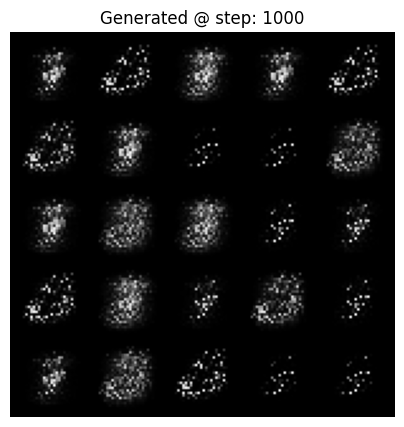

2000 gen_loss: 4.3816, disc_loss: 0.1495


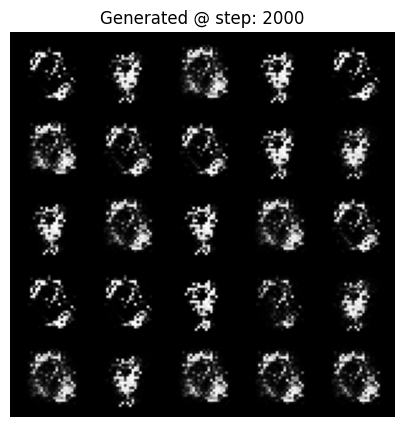

3000 gen_loss: 4.3273, disc_loss: 0.1194


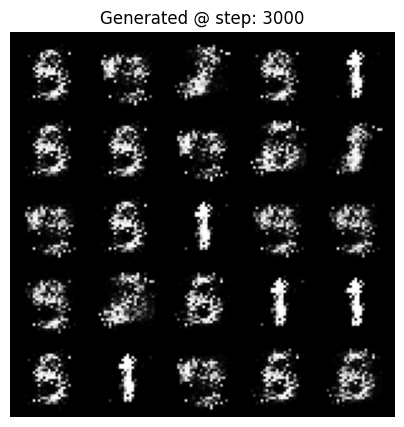

4000 gen_loss: 4.2418, disc_loss: 0.1975


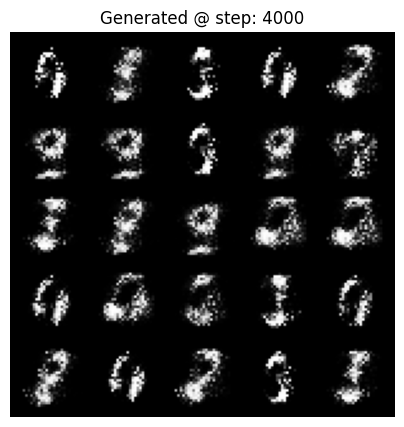

5000 gen_loss: 4.3932, disc_loss: 0.0559


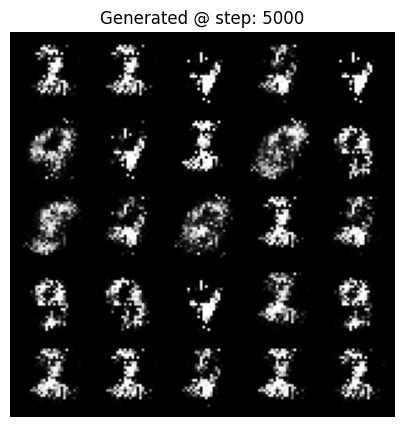

6000 gen_loss: 4.5530, disc_loss: 0.1595


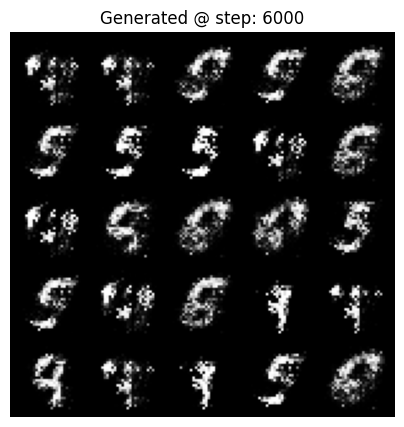

7000 gen_loss: 3.1023, disc_loss: 0.1543


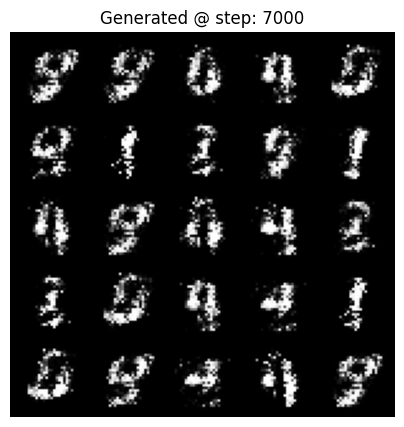

8000 gen_loss: 3.9553, disc_loss: 0.2449


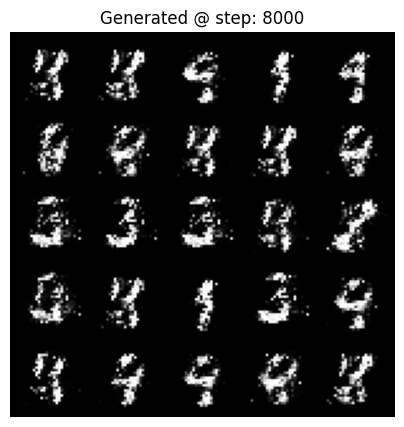

9000 gen_loss: 3.4993, disc_loss: 0.0590


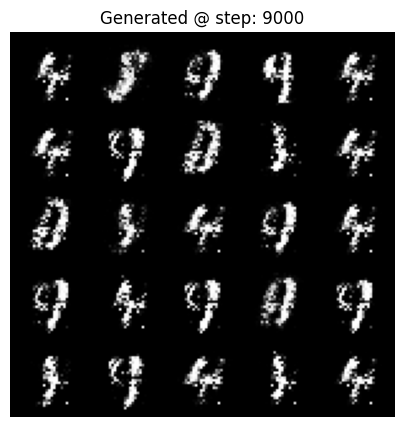

10000 gen_loss: 3.4595, disc_loss: 0.0500


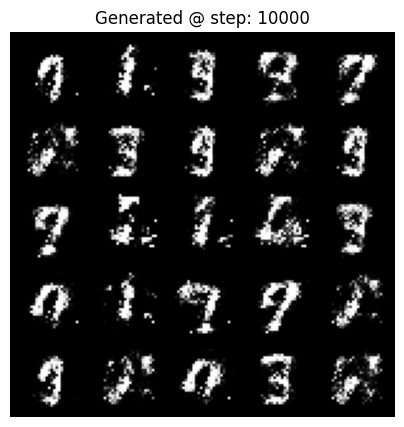

11000 gen_loss: 3.3639, disc_loss: 0.1349


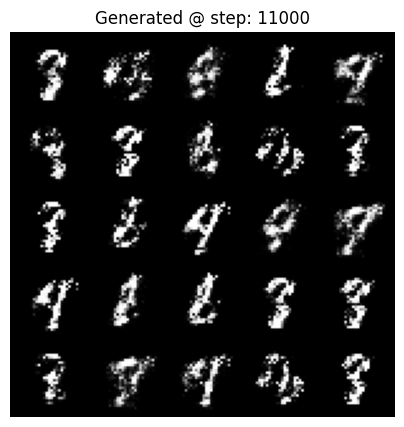

12000 gen_loss: 4.1870, disc_loss: 0.0815


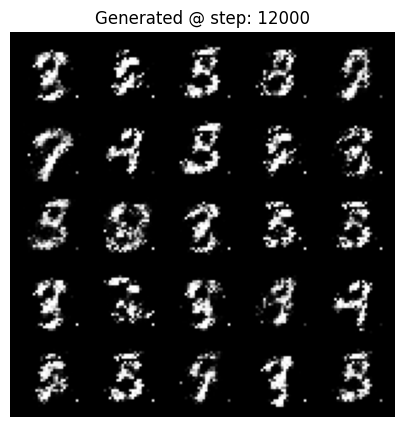

13000 gen_loss: 3.6678, disc_loss: 0.1296


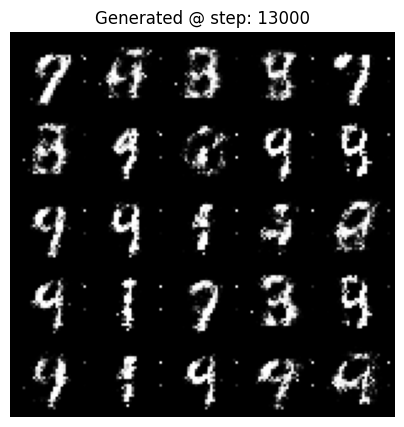

14000 gen_loss: 3.2171, disc_loss: 0.1405


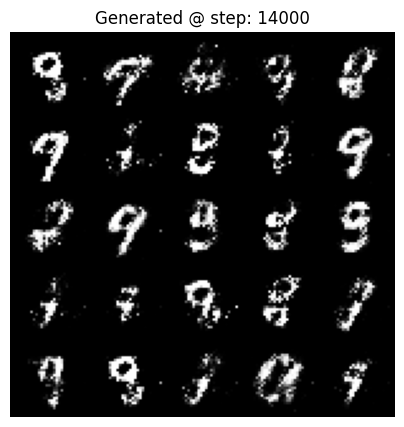

15000 gen_loss: 3.1298, disc_loss: 0.2568


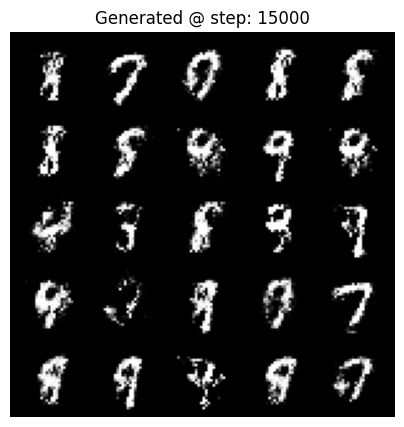

16000 gen_loss: 3.2016, disc_loss: 0.1901


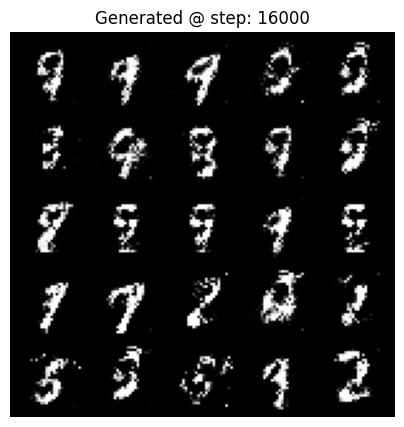

17000 gen_loss: 2.6305, disc_loss: 0.1814


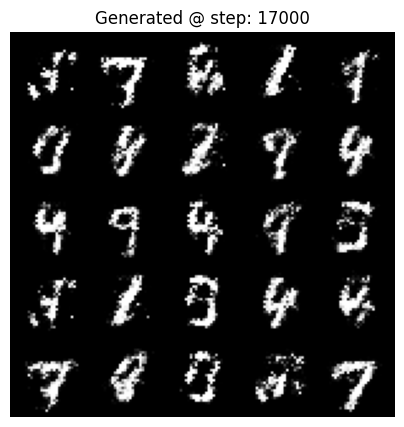

18000 gen_loss: 2.4098, disc_loss: 0.2876


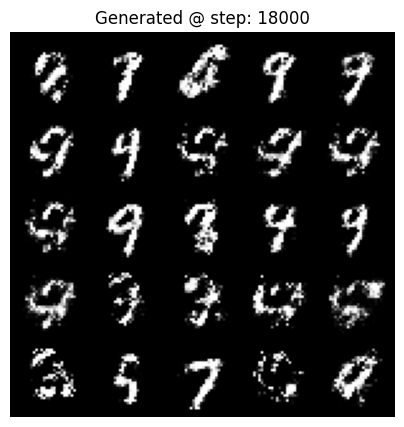

19000 gen_loss: 2.8704, disc_loss: 0.1922


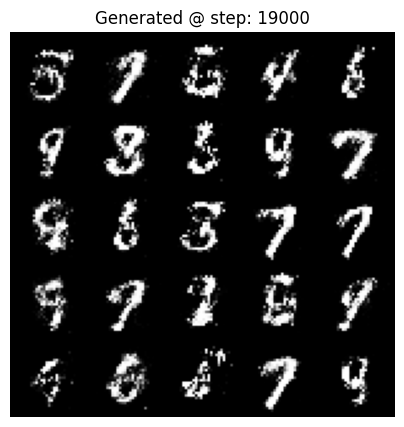

20000 gen_loss: 2.6205, disc_loss: 0.2433


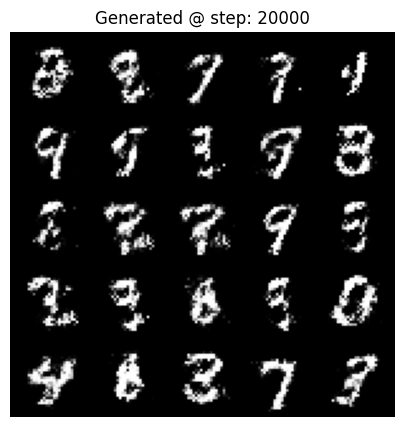

21000 gen_loss: 2.8968, disc_loss: 0.1689


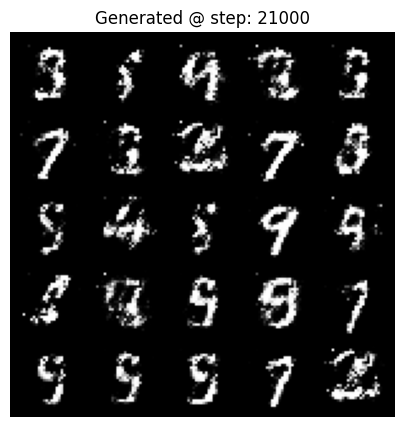

22000 gen_loss: 2.3560, disc_loss: 0.3386


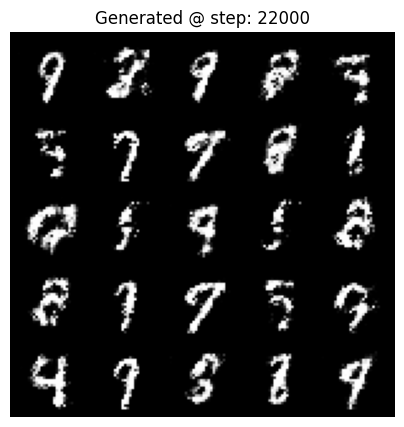

23000 gen_loss: 2.4938, disc_loss: 0.2590


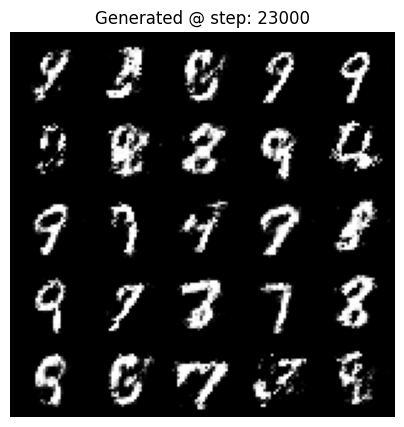

24000 gen_loss: 2.5400, disc_loss: 0.3788


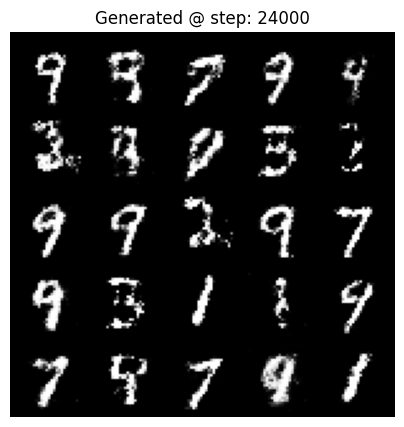

25000 gen_loss: 1.7571, disc_loss: 0.4378


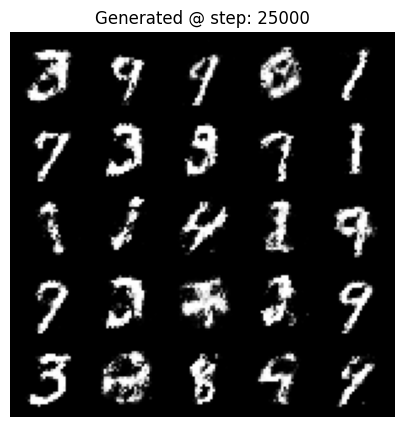

26000 gen_loss: 1.9873, disc_loss: 0.3246


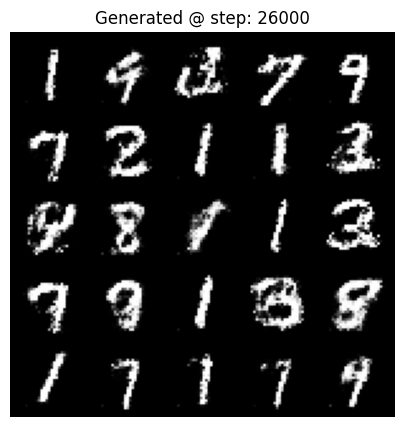

27000 gen_loss: 1.8191, disc_loss: 0.3630


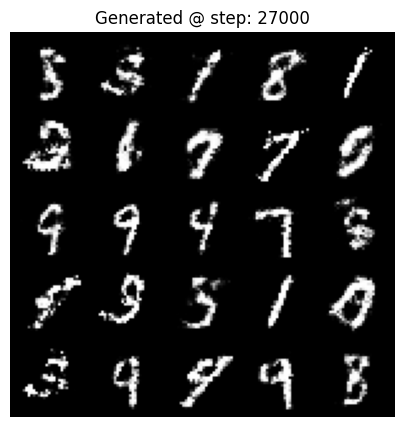

28000 gen_loss: 1.6904, disc_loss: 0.4508


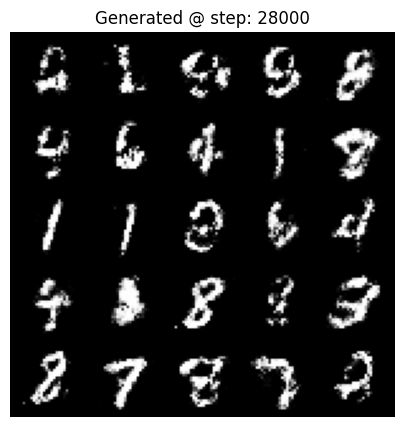

29000 gen_loss: 1.7550, disc_loss: 0.5266


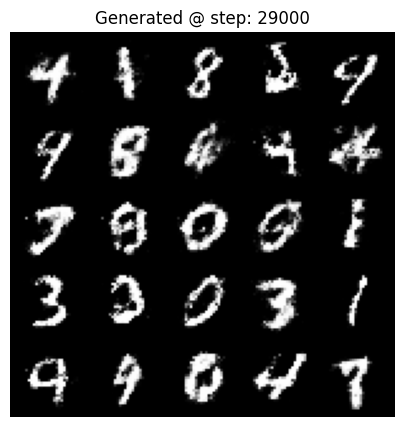

30000 gen_loss: 1.3384, disc_loss: 0.4353


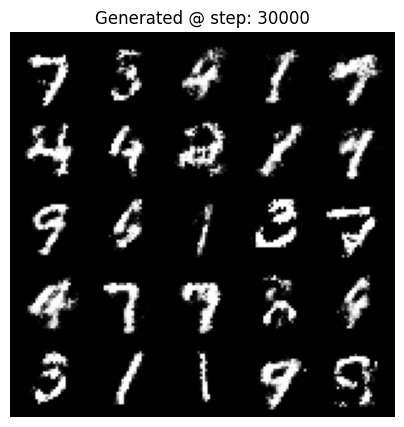

31000 gen_loss: 1.7712, disc_loss: 0.4274


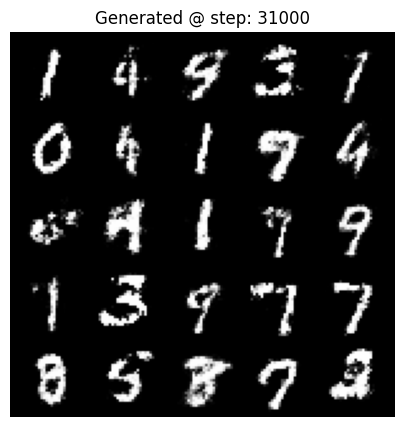

32000 gen_loss: 1.4602, disc_loss: 0.4369


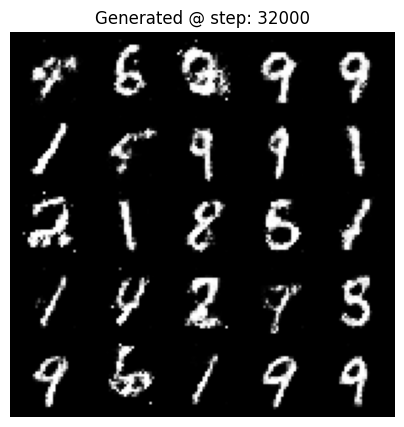

33000 gen_loss: 1.3262, disc_loss: 0.5699


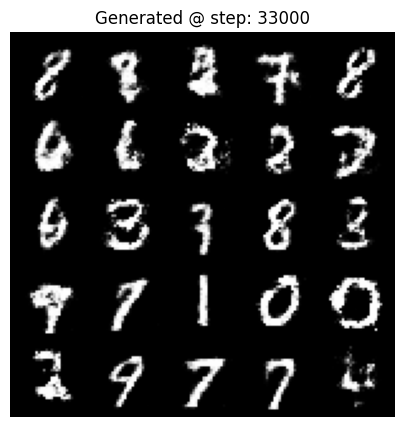

34000 gen_loss: 1.3419, disc_loss: 0.4746


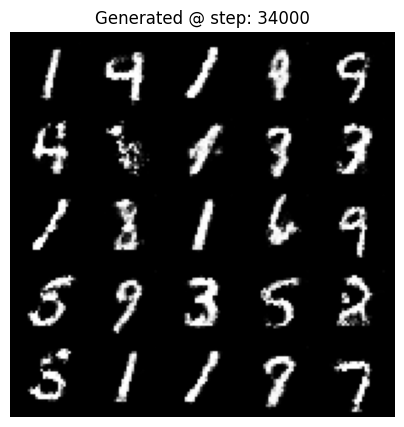

35000 gen_loss: 1.3086, disc_loss: 0.5069


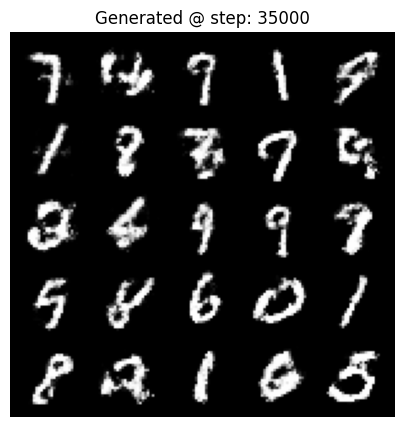

36000 gen_loss: 1.3894, disc_loss: 0.4441


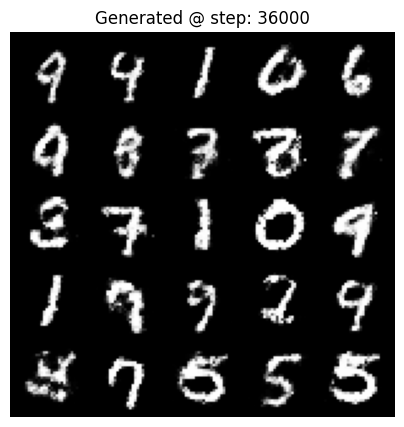

37000 gen_loss: 1.3053, disc_loss: 0.5547


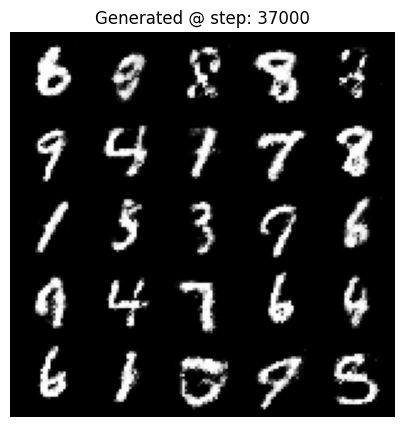

38000 gen_loss: 1.1884, disc_loss: 0.4569


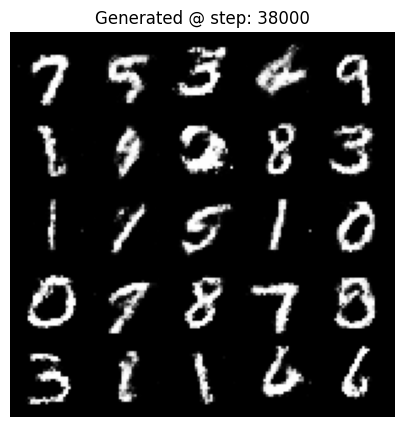

39000 gen_loss: 1.1393, disc_loss: 0.4889


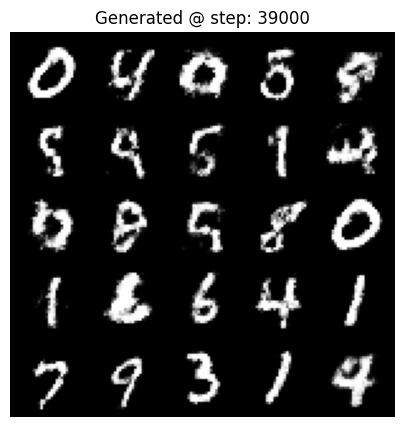

40000 gen_loss: 1.2504, disc_loss: 0.5256


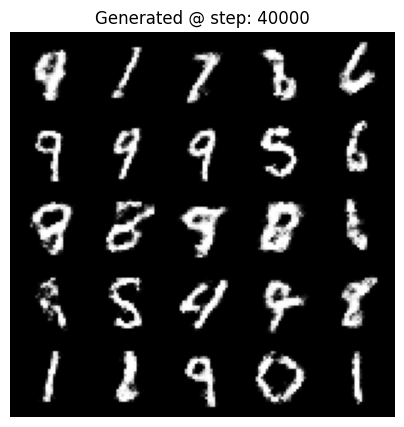

41000 gen_loss: 1.1292, disc_loss: 0.6285


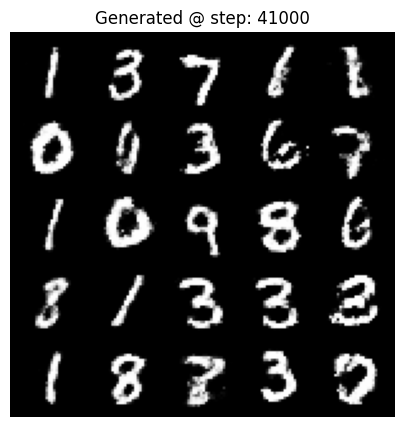

42000 gen_loss: 1.2110, disc_loss: 0.5653


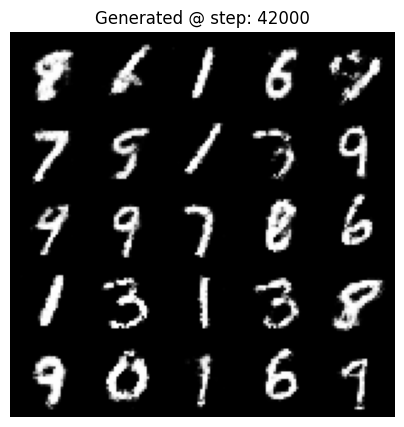

43000 gen_loss: 1.3227, disc_loss: 0.5979


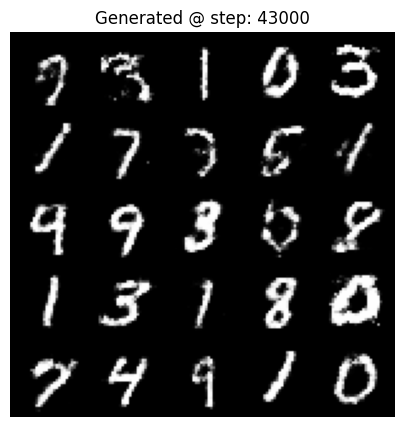

44000 gen_loss: 1.2395, disc_loss: 0.5481


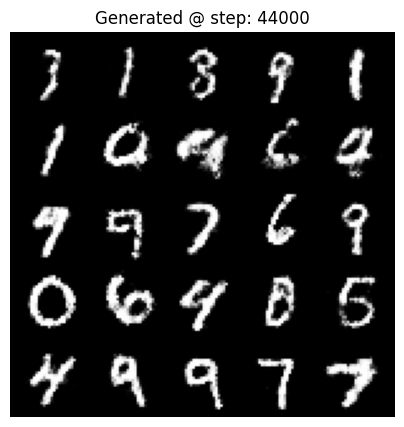

45000 gen_loss: 1.0045, disc_loss: 0.6152


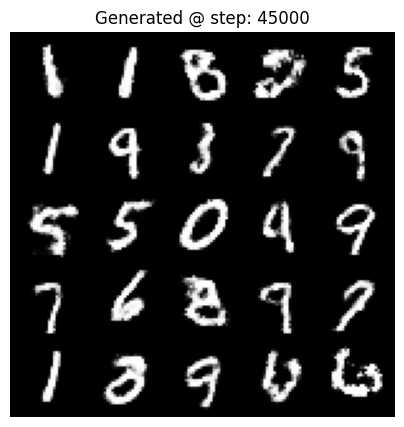

46000 gen_loss: 1.1566, disc_loss: 0.4554


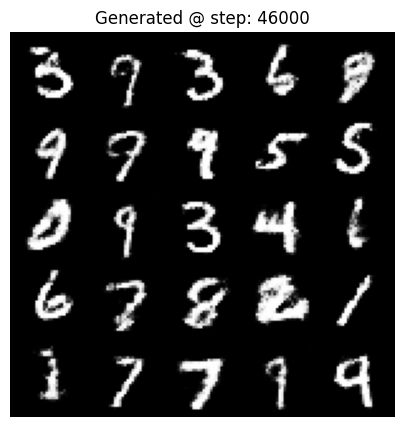

47000 gen_loss: 1.2270, disc_loss: 0.5348


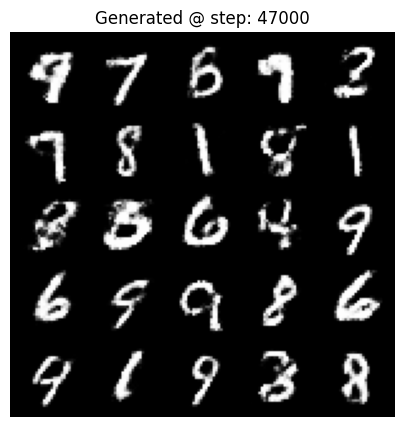

48000 gen_loss: 1.3187, disc_loss: 0.4769


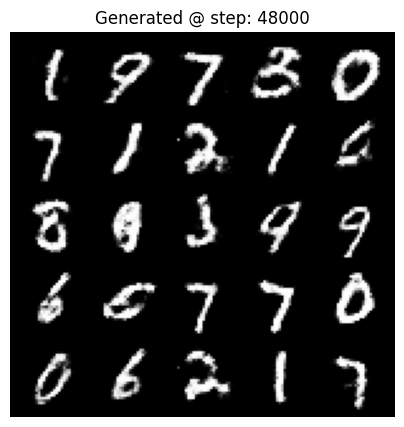

49000 gen_loss: 1.1671, disc_loss: 0.4942


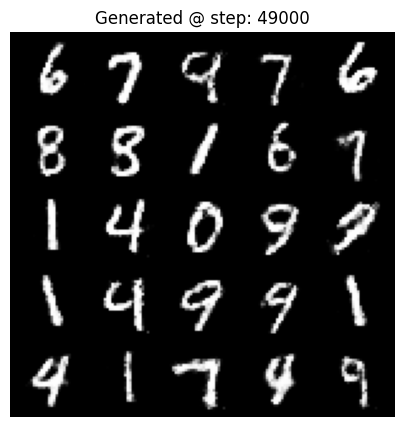

50000 gen_loss: 1.3337, disc_loss: 0.4821


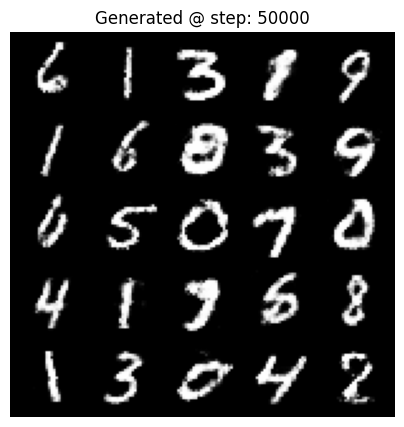

51000 gen_loss: 1.2045, disc_loss: 0.6010


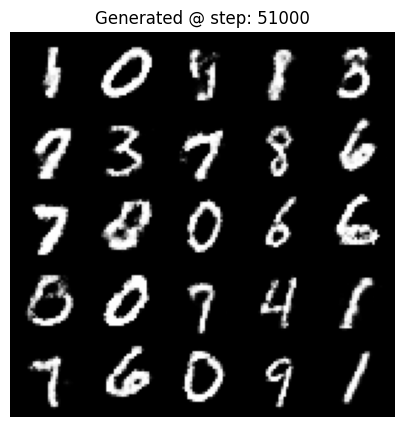

52000 gen_loss: 1.1607, disc_loss: 0.5313


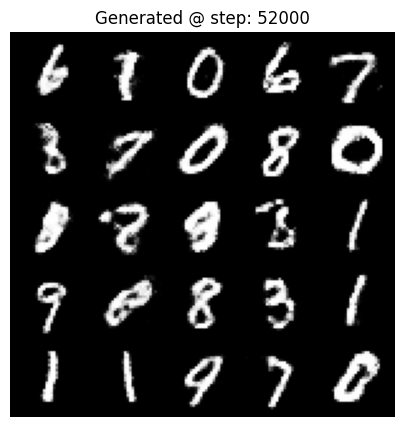

53000 gen_loss: 1.2841, disc_loss: 0.4655


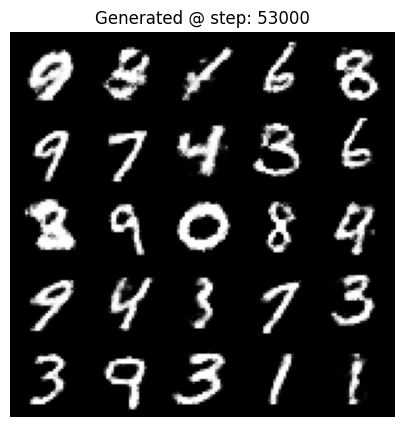

54000 gen_loss: 1.2967, disc_loss: 0.5359


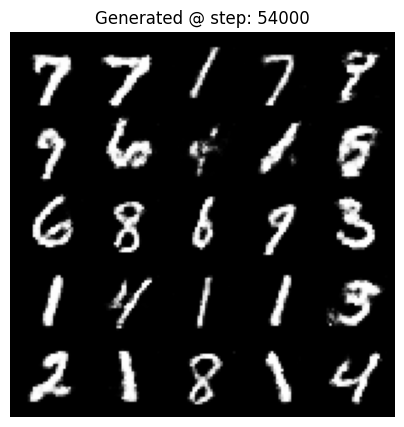

55000 gen_loss: 1.1836, disc_loss: 0.5245


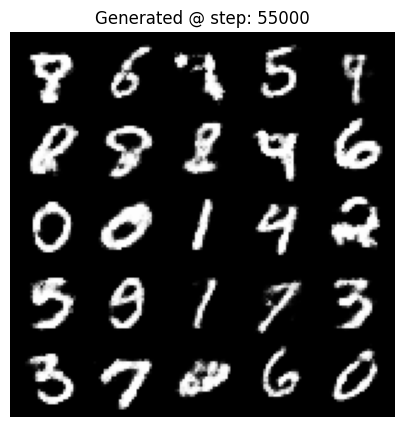

56000 gen_loss: 1.2247, disc_loss: 0.4903


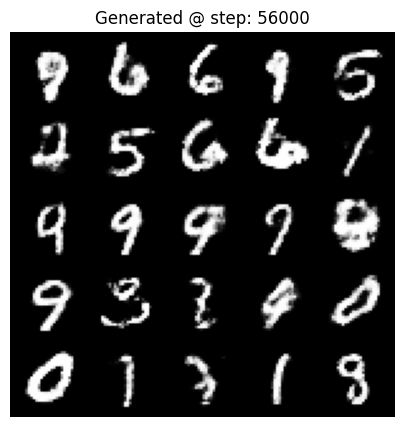

57000 gen_loss: 1.0827, disc_loss: 0.5228


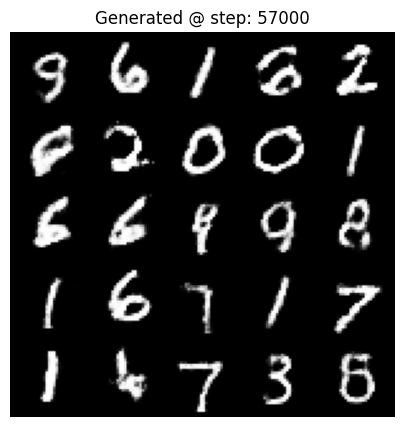

58000 gen_loss: 1.3622, disc_loss: 0.4840


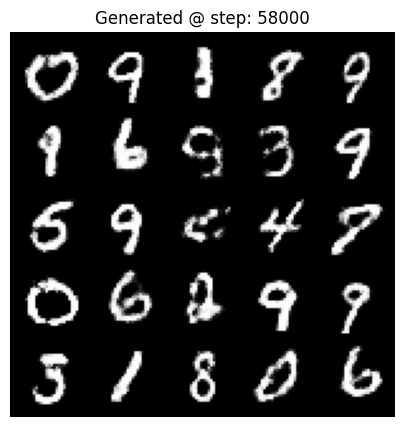

59000 gen_loss: 1.3603, disc_loss: 0.5887


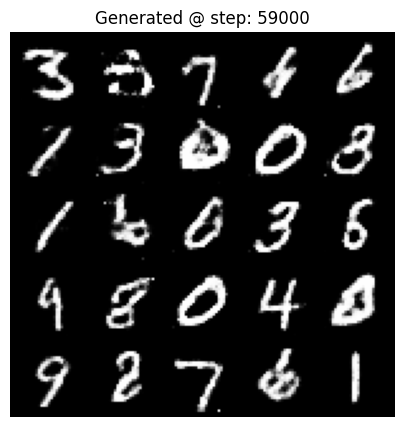

60000 gen_loss: 1.1423, disc_loss: 0.5367


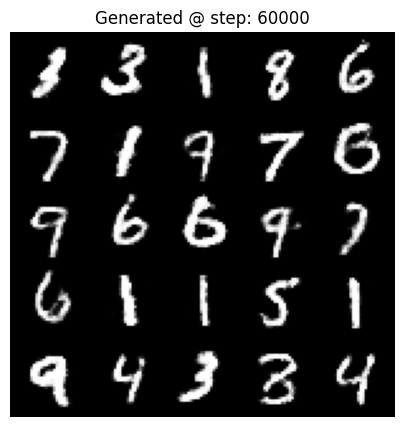

61000 gen_loss: 1.0831, disc_loss: 0.5261


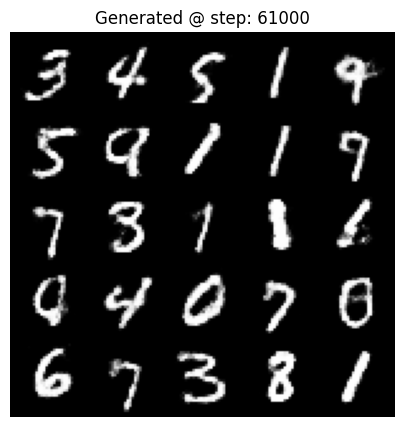

62000 gen_loss: 1.1636, disc_loss: 0.4981


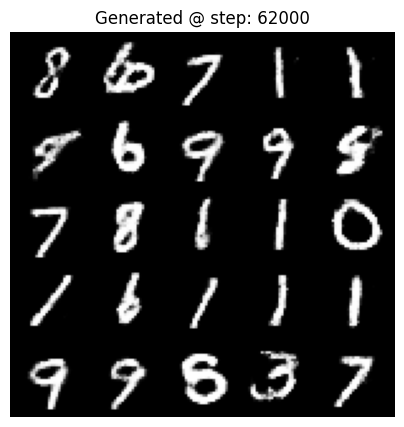

63000 gen_loss: 1.1343, disc_loss: 0.5392


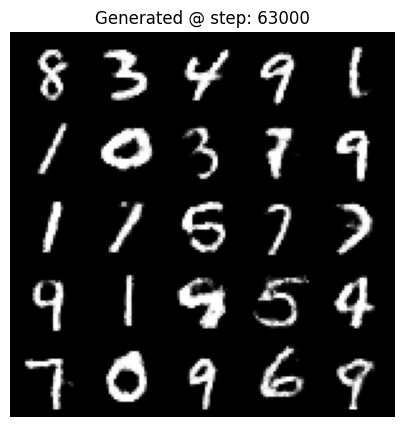

64000 gen_loss: 1.0506, disc_loss: 0.5538


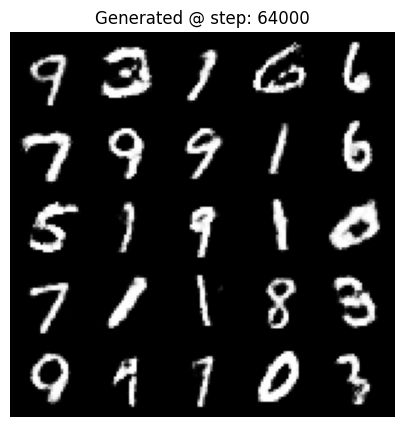

65000 gen_loss: 1.0270, disc_loss: 0.5343


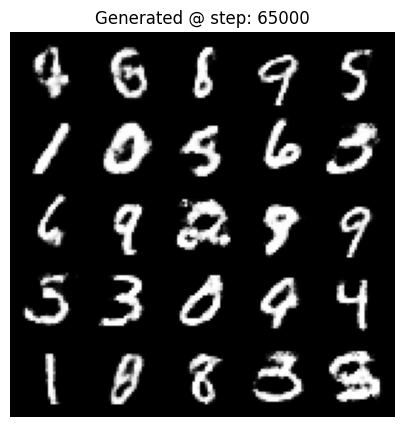

66000 gen_loss: 1.2504, disc_loss: 0.4923


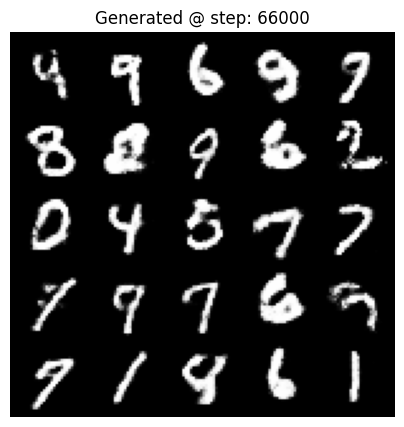

67000 gen_loss: 1.0753, disc_loss: 0.5840


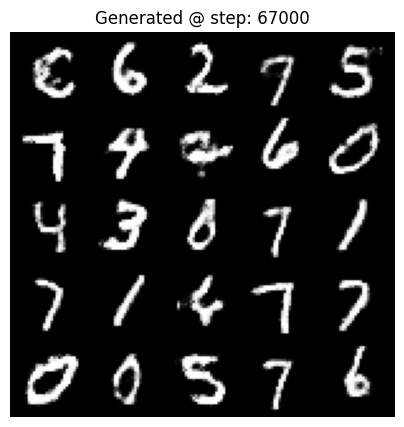

68000 gen_loss: 1.1904, disc_loss: 0.5414


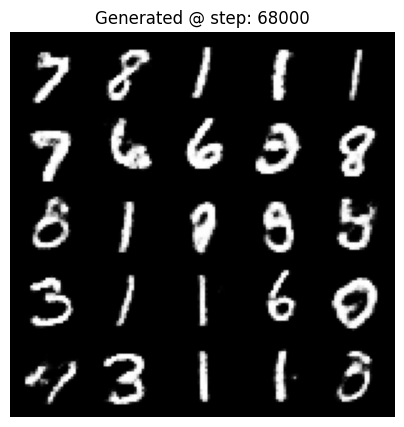

69000 gen_loss: 1.2385, disc_loss: 0.5155


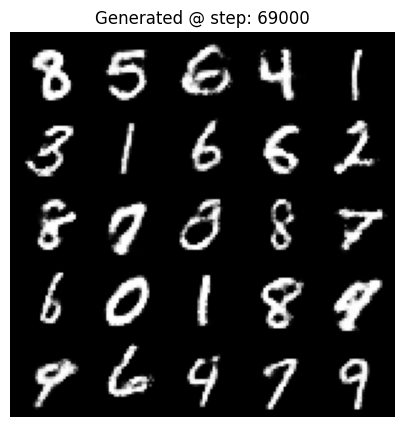

70000 gen_loss: 1.2090, disc_loss: 0.6367


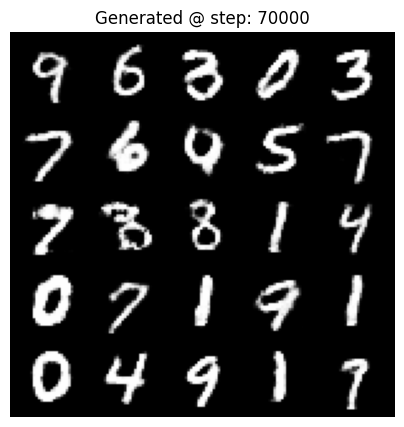

71000 gen_loss: 1.0785, disc_loss: 0.5877


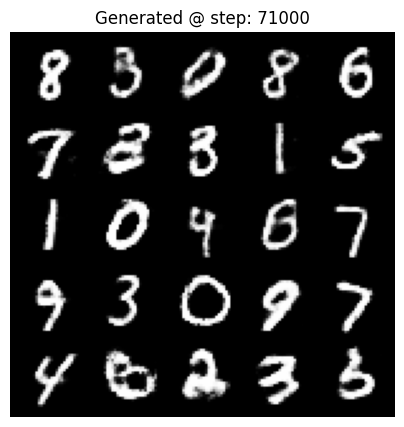

72000 gen_loss: 1.3674, disc_loss: 0.5385


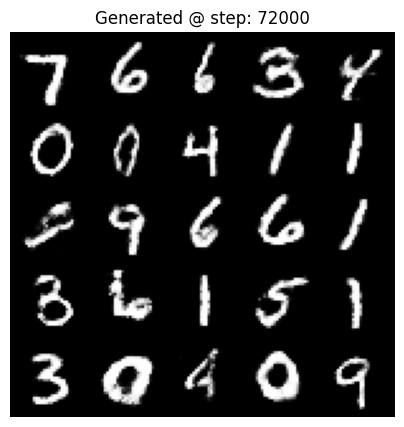

73000 gen_loss: 1.1187, disc_loss: 0.5560


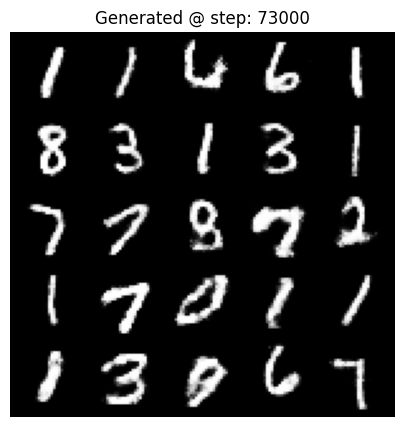

74000 gen_loss: 1.1619, disc_loss: 0.6108


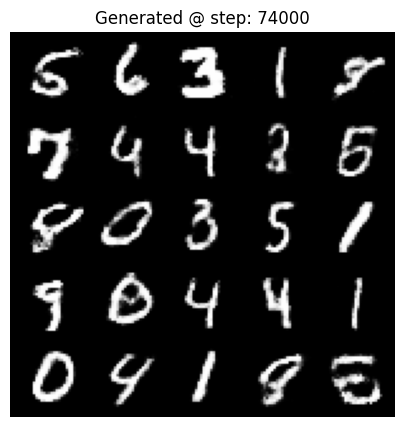

75000 gen_loss: 1.1634, disc_loss: 0.5596


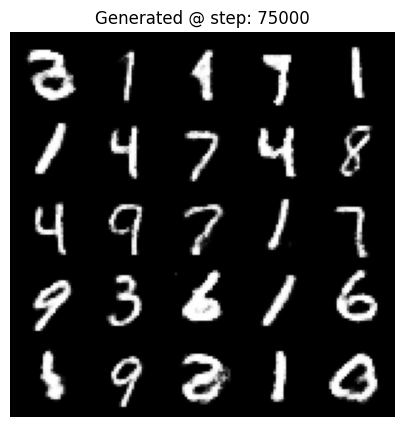

76000 gen_loss: 1.2381, disc_loss: 0.4726


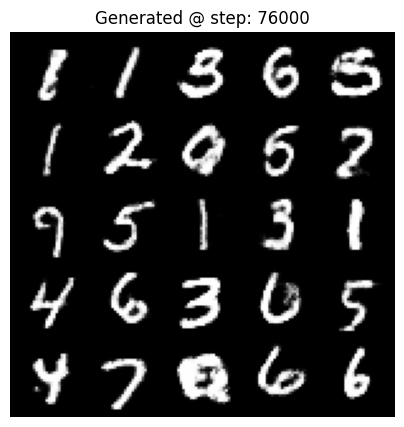

77000 gen_loss: 1.2809, disc_loss: 0.5625


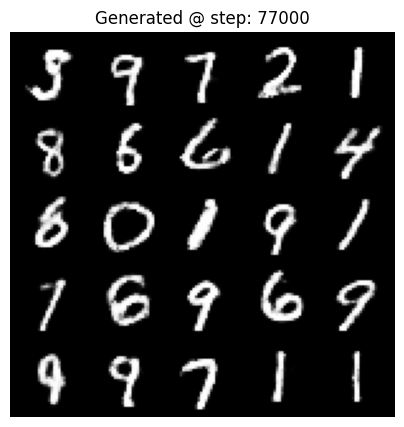

78000 gen_loss: 1.3954, disc_loss: 0.4997


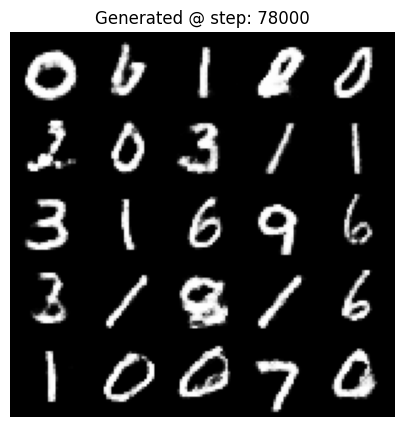

79000 gen_loss: 1.1952, disc_loss: 0.5074


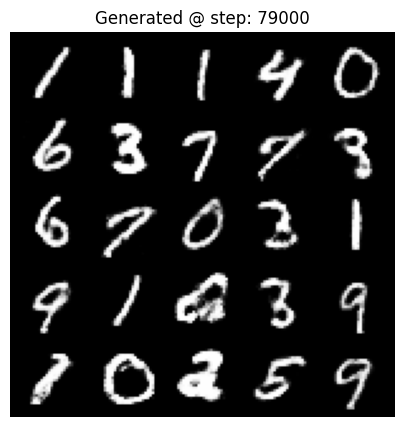

80000 gen_loss: 1.2264, disc_loss: 0.5424


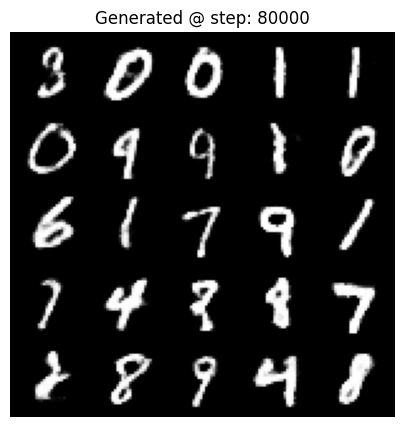

81000 gen_loss: 1.2597, disc_loss: 0.5727


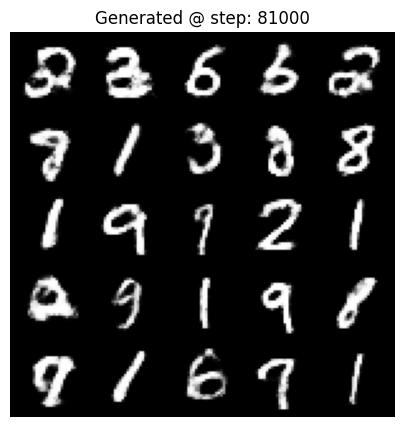

82000 gen_loss: 1.0904, disc_loss: 0.4456


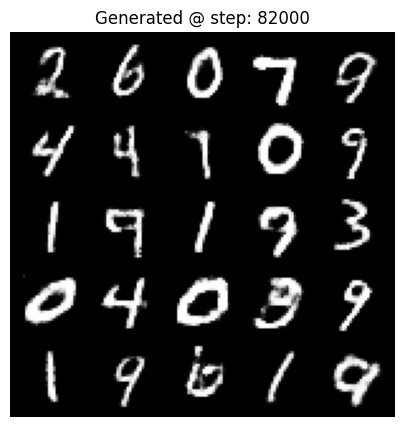

83000 gen_loss: 1.0325, disc_loss: 0.5967


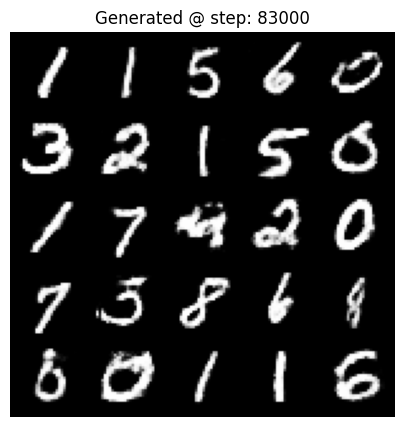

84000 gen_loss: 1.0869, disc_loss: 0.5695


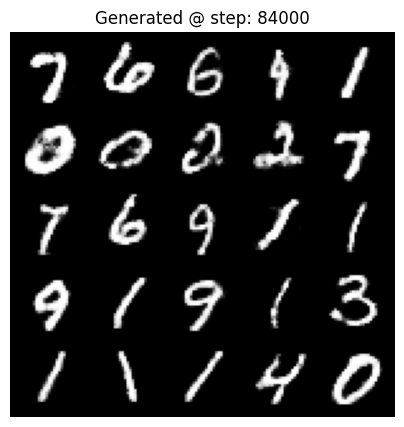

85000 gen_loss: 1.1056, disc_loss: 0.5215


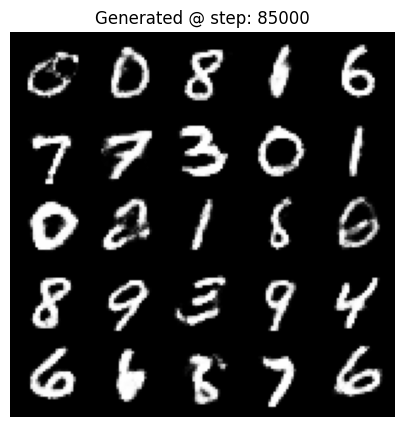

86000 gen_loss: 1.1795, disc_loss: 0.5372


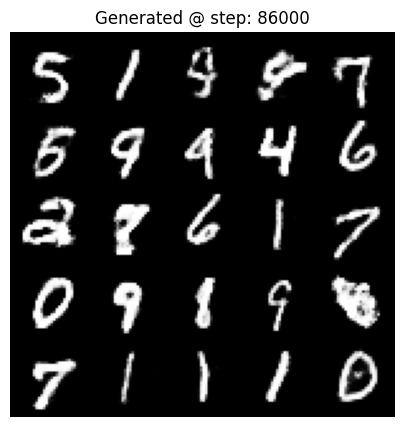

87000 gen_loss: 1.2741, disc_loss: 0.5137


KeyboardInterrupt: 

In [36]:
train(generator, discriminator, nn.BCEWithLogitsLoss(), images, 64, 10, device, alpha=0.5)

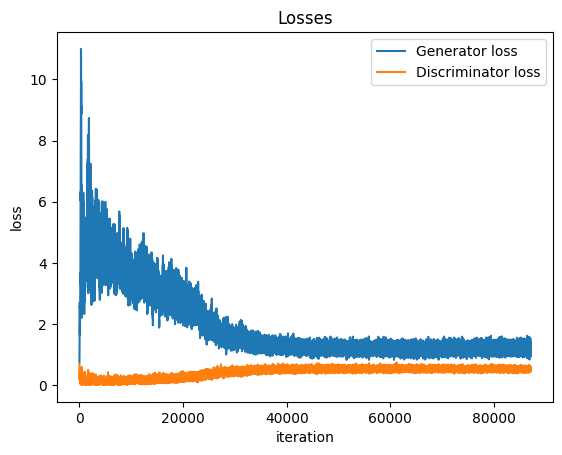

In [37]:
# plot the losses
plt.title("Losses")
plt.ylabel("loss")
plt.xlabel("iteration")
plt.plot(gen_losses, label="Generator loss")
plt.plot(disc_losses, label="Discriminator loss")
plt.legend()
plt.show()